# BUDHA


In [1]:
%load_ext autoreload
%autoreload 2

## Datos del budha

In [2]:
checkerboard = (10, 7) # (points_per_row, points_per_colum)
square_size_mm = 24.2 # square side size in millimeters


In [3]:
from calib import board_points

# creamos los puntos del mundo del objeto checkerboard
checkerboard_world_points_mm = board_points(checkerboard) * square_size_mm

In [4]:
import glob, os

directory = os.path.join("datasets","stereo_budha_board", "calib")
left_files_pattern = "*left*.jpg"
right_files_pattern = "*right*.jpg"

def numeric_sort(file_name):
    return int(file_name.split("_")[-1].split(".")[0])

left_file_names = sorted(
    glob.glob(
        os.path.join(directory, left_files_pattern)
    ),
    key=numeric_sort
)

right_file_names = sorted(
    glob.glob(
        os.path.join(directory, right_files_pattern)
    ),
    key=numeric_sort
)

num_left = len(left_file_names)
num_right = len(right_file_names)





# --- AÑADE ESTAS LÍNEAS PARA DEPURAR ---
print(f"Directorio de búsqueda: {directory}")
print(f"Ruta absoluta: {os.path.abspath(directory)}")
print(f"Archivos izquierdos encontrados: {num_left}")
print(f"Archivos derechos encontrados: {num_right}")

if num_left > 0:
    print(f"Ejemplo de archivo izquierdo: {left_file_names[0]}")
# --- FIN DE LÍNEAS DE DEPURACIÓN ---

if  num_left != num_right:
    raise Exception(f"the number of files (left {num_left} / right{num_right}) doesn't match")




Directorio de búsqueda: datasets\stereo_budha_board\calib
Ruta absoluta: c:\vision_artificial\tp2_git\tp2_reconstruccion_3d\datasets\stereo_budha_board\calib
Archivos izquierdos encontrados: 28
Archivos derechos encontrados: 28
Ejemplo de archivo izquierdo: datasets\stereo_budha_board\calib\calib_left_0.jpg


In [5]:
import cv2

image_size = None
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)

world_points = []
left_images = []
right_images = []
left_images_points = []
right_images_points = []

for left_file_name, right_file_name in zip(
    left_file_names, right_file_names
):

    print("processing", left_file_name, right_file_name)

    # read left and right images
    left_image = cv2.imread(left_file_name, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_file_name, cv2.IMREAD_GRAYSCALE)

    # get the images sizes
    left_size = (left_image.shape[1], left_image.shape[0])
    right_size = (right_image.shape[1], right_image.shape[0])

    # checks that images sizes match
    if left_size != right_size:
        raise Exception(f"left and right images sizes differ: left {left_size} / right {right_size}")
        
    if image_size is None:
        # remembers the images size
        image_size = left_size
    else:
        if image_size != left_size:
            raise Exception(f"there are images with different sizes: {image_size} vs {left_size}")

    # finds the checkerboard in each image
    left_found, left_corners = cv2.findChessboardCorners(left_image, checkerboard)
    right_found, right_corners = cv2.findChessboardCorners(right_image, checkerboard)

    if not left_found or not right_found:
        print("warning, checkerboard was not found")
        continue

    # checkerboard was found in both images.

    # let's improve the found corners
    corners_left = cv2.cornerSubPix(left_image, left_corners, (7, 7), (-1,-1), criteria)
    corners_right = cv2.cornerSubPix(right_image, right_corners, (7, 7), (-1,-1), criteria)

    # acumulo las imagenes
    left_images.append(left_image)
    right_images.append(right_image)

    # acumulo los corners detectados
    left_images_points.append(left_corners)
    right_images_points.append(right_corners)

    # acumulo los puntos del mundo
    world_points.append(checkerboard_world_points_mm)

print(f"Imágenes izquierdas: {len(left_images)}")
print(f"Imágenes derechas: {len(right_images)}")

processing datasets\stereo_budha_board\calib\calib_left_0.jpg datasets\stereo_budha_board\calib\calib_right_0.jpg
processing datasets\stereo_budha_board\calib\calib_left_1.jpg datasets\stereo_budha_board\calib\calib_right_1.jpg
processing datasets\stereo_budha_board\calib\calib_left_2.jpg datasets\stereo_budha_board\calib\calib_right_2.jpg
processing datasets\stereo_budha_board\calib\calib_left_3.jpg datasets\stereo_budha_board\calib\calib_right_3.jpg
processing datasets\stereo_budha_board\calib\calib_left_4.jpg datasets\stereo_budha_board\calib\calib_right_4.jpg
processing datasets\stereo_budha_board\calib\calib_left_5.jpg datasets\stereo_budha_board\calib\calib_right_5.jpg
processing datasets\stereo_budha_board\calib\calib_left_6.jpg datasets\stereo_budha_board\calib\calib_right_6.jpg
processing datasets\stereo_budha_board\calib\calib_left_7.jpg datasets\stereo_budha_board\calib\calib_right_7.jpg
processing datasets\stereo_budha_board\calib\calib_left_8.jpg datasets\stereo_budha_boar

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None, ax=None, figsize=(5, 5)):
    """
    Muestra una imagen (convirtiendo de BGR a RGB si es necesario).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Asumir que es BGR si tiene 3 canales, convertir a RGB
    # (OpenCV lee en BGR, Matplotlib muestra en RGB)
    if img.ndim == 3 and img.shape[2] == 3:
        img_rgb = img[..., ::-1]  # Convertir BGR a RGB
        ax.imshow(img_rgb)
    # Si es 2D (escala de grises)
    elif img.ndim == 2:
        ax.imshow(img, cmap='gray')
    # Si ya está en RGB o es otro formato
    else:
        ax.imshow(img)
        
    ax.axis('off')
    if title:
        ax.set_title(title)
    
    return ax

def show_images(images, titles=None, figsize_per_img=(5, 5)):
    """
    Muestra una lista de imágenes una al lado de la otra.
    
    images: lista de imágenes [img1, img2, ...]
    titles: lista de títulos [title1, title2, ...]
    """
    n = len(images)
    if n == 0:
        print("No hay imágenes para mostrar.")
        return

    if titles is None:
        titles = [''] * n
    
    if len(images) != len(titles):
        raise ValueError("La lista de imágenes y de títulos debe tener el mismo tamaño.")

    # Calcular el tamaño total de la figura
    figsize = (figsize_per_img[0] * n, figsize_per_img[1])
    
    fig, axes = plt.subplots(1, n, figsize=figsize)
    
    # Asegurarse de que 'axes' sea siempre una lista para poder iterar
    if n == 1:
        axes = [axes]
        
    for ax, img, title in zip(axes, images, titles):
        # Usar la función helper 'imshow'
        imshow(img, title, ax=ax)
    
    plt.tight_layout()
    plt.show()


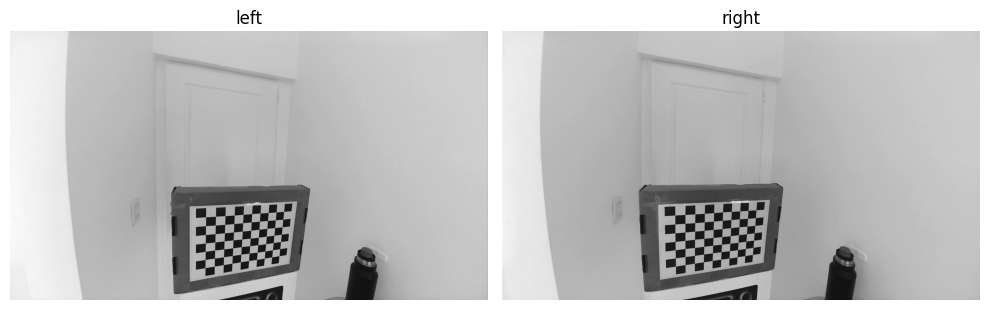

In [29]:
show_images([
    left_images[14], right_images[14]
], ['left', 'right'])

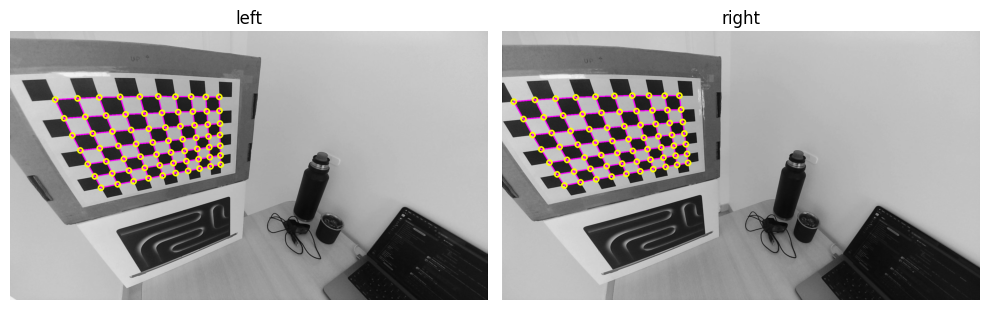

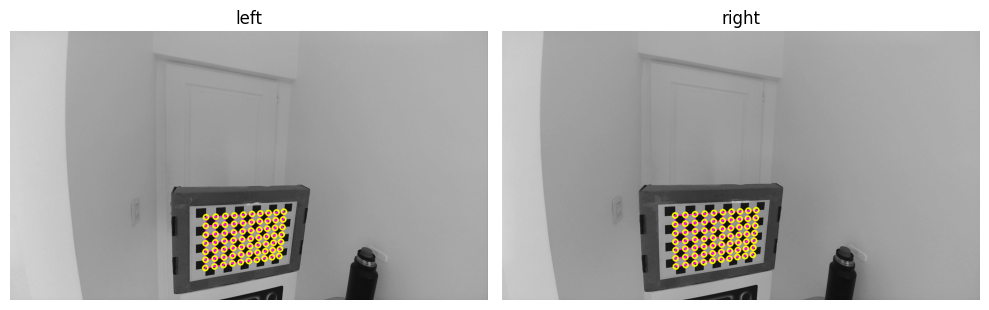

In [7]:
# grafiquemos algunos checkerboards
# y sus detecciones de corners
#  para verificar que lo que encontró está ok:

import calib
some_images_indices = [5, 14]

draw_settings = {
    "corner_radius": 10,
    "corner_thickness": 5,
    "line_thickness": 4
}
for i in some_images_indices:

    left_img, right_img = left_images[i], right_images[i]
    left_corners, right_corners = left_images_points[i], right_images_points[i]

    show_left = cv2.cvtColor(left_img, cv2.COLOR_GRAY2BGR)
    show_right = cv2.cvtColor(right_img, cv2.COLOR_GRAY2BGR)


    calib.draw_checkerboard(show_left, checkerboard, left_corners, True, **draw_settings)
    calib.draw_checkerboard(show_right, checkerboard, right_corners, True, **draw_settings)
    

    show_images([show_left, show_right], ["left", "right"])
    


In [8]:
# Calibramos Stereo

print("Calibrating Stereo")
print("num images:", len(left_images_points))

err, left_K, left_dist, right_K, right_dist, R, T, E, F = cv2.stereoCalibrate(
    world_points, 
    left_images_points, 
    right_images_points, 
    None, 
    None, 
    None, 
    None, 
    image_size, 
    flags=0
)

Calibrating Stereo
num images: 28


In [9]:
from calib import np_print

to_print = [

    "# Left camera Intrinsics:",
    ("left_K", left_K),
    ("left_dist", left_dist),

    "# Right camera Intrinsics:",
    ("right_K", right_K),
    ("right_dist", right_dist),

    "# Rotation:",
    ("R", R),

    "# Translation:",
    ("T", T),
    
    "# Essential Matrix:",
    ("E", E),
    
    "# Fundamental Matrix:",
    ("F", F),
        
]

In [10]:
print("# STEREO CALIBRATION")
for line in to_print:

    if isinstance(line, str):   
        print(line)
    else:
        var_name, np_array = line
        print(f"{var_name} = {np_print(np_array)}\n")

# STEREO CALIBRATION
# Left camera Intrinsics:
left_K = np.array([
	[   600.569,	     0.000,	   963.433],
	[     0.000,	   600.775,	   548.961],
	[     0.000,	     0.000,	     1.000]
])

left_dist = np.array([
	[  0.004782,	 -0.023202,	 -0.000496,	  0.001601,	  0.003510]
])

# Right camera Intrinsics:
right_K = np.array([
	[   600.059,	     0.000,	   960.028],
	[     0.000,	   599.822,	   535.499],
	[     0.000,	     0.000,	     1.000]
])

right_dist = np.array([
	[  0.001949,	 -0.021507,	 -0.000628,	  0.000322,	  0.003217]
])

# Rotation:
R = np.array([
	[     1.000,	    -0.000,	     0.010],
	[     0.000,	     1.000,	     0.010],
	[    -0.010,	    -0.010,	     1.000]
])

# Translation:
T = np.array([
	[-59.300782],
	[  0.584879],
	[ -0.325488]
])

# Essential Matrix:
E = np.array([
	[    -0.006,	     0.320,	     0.588],
	[    -0.917,	    -0.571,	    59.292],
	[    -0.589,	   -59.298,	    -0.577]
])

# Fundamental Matrix:
F = np.array([
	[     0.000,	    -0.000,	    -0.001],
	[     0.0

In [11]:
# serializamos los resultados en un pickle
import pickle

calibration_results = {
    'left_K': left_K,
    'left_dist': left_dist,
    'right_K': right_K,
    'right_dist': right_dist,
    'R': R,
    'T': T,
    'E': E,
    'F': F,
    'image_size': image_size,
}

calibration_file = os.path.join("datasets","stereo_budha_board" ,"stereo_calibration.pkl")
with open(calibration_file, "wb") as f:
    f.write(pickle.dumps(calibration_results))
        


In [12]:
# para recuperar los resultados podemos cargarlos usando pickle:

with open(calibration_file, "rb") as f:
    results2 = pickle.loads(f.read())


results2.keys()

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])

In [13]:
# realicemos la rectificación estéreo:

R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(
    left_K, left_dist, right_K, right_dist, image_size, R, T, alpha=0
)


## Mapas

In [14]:
# calculemos los mapas de des-distorsión-rectificación:

left_map_x, left_map_y = cv2.initUndistortRectifyMap(left_K, left_dist, R1, P1, image_size, cv2.CV_32FC1)
right_map_x, right_map_y = cv2.initUndistortRectifyMap(right_K, right_dist, R2, P2, image_size, cv2.CV_32FC1)
left_map_x.shape
left_map_x[0:3, 0:3]

array([[103.381454, 104.13572 , 104.88958 ],
       [103.30606 , 104.05991 , 104.81338 ],
       [103.23055 , 103.98401 , 104.73707 ]], dtype=float32)

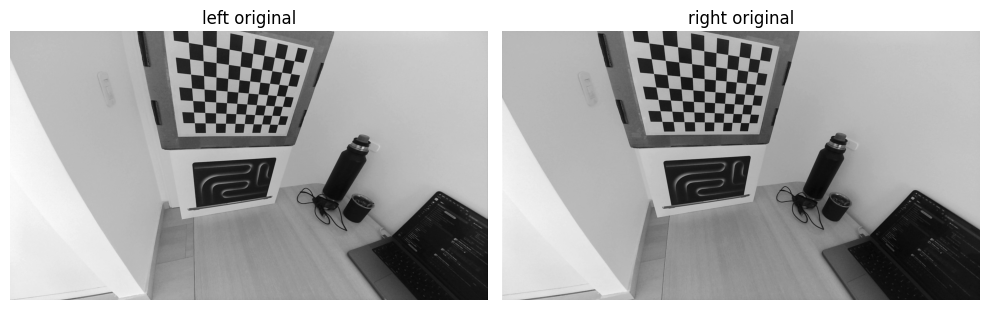

In [15]:
# tomemos un par estéreo
image_index = 3

left_image = left_images[image_index]
right_image = right_images[image_index]


show_images([
    left_image, right_image
], [
    "left original", "right original"
])

In [16]:
# aplicamos des-distorsion + rectificación, con los mapas que calculamos ateriormente
left_image_rectified = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
right_image_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)




# Ejemplo, para saber qué valor poner en la posición (i,j) de la imagen destino,
# a cuál píxel en la imagen original tendríamos que ir buscar?
x_dest, y_dest = 321, 123

x_ori = left_map_x[y_dest, x_dest]
y_ori = left_map_y[y_dest, x_dest]

x_ori = int(np.round(x_ori))
y_ori = int(np.round(y_ori))

print(f"using nearest neighbor interpolation, I_dest[{y_dest}, {x_dest}] = I_ori[{y_ori}, {x_ori}]")

print(left_image[y_ori, x_ori])
print(left_image_rectified[y_dest, x_dest])


using nearest neighbor interpolation, I_dest[123, 321] = I_ori[145, 347]
175
175


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None, ax=None, figsize=(5, 5)):
    """
    Muestra una imagen (convirtiendo de BGR a RGB si es necesario).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Asumir que es BGR si tiene 3 canales, convertir a RGB
    # (OpenCV lee en BGR, Matplotlib muestra en RGB)
    if img.ndim == 3 and img.shape[2] == 3:
        img_rgb = img[..., ::-1]  # Convertir BGR a RGB
        ax.imshow(img_rgb)
    # Si es 2D (escala de grises)
    elif img.ndim == 2:
        ax.imshow(img, cmap='gray')
    # Si ya está en RGB o es otro formato
    else:
        ax.imshow(img)
        
    ax.axis('off')
    if title:
        ax.set_title(title)
    
    return ax

def show_images(images, titles=None, figsize_per_img=(5, 5)):
    """
    Muestra una lista de imágenes una al lado de la otra.
    
    images: lista de imágenes [img1, img2, ...]
    titles: lista de títulos [title1, title2, ...]
    """
    n = len(images)
    if n == 0:
        print("No hay imágenes para mostrar.")
        # Devolvemos None para ambos para que el unpacking no falle
        return None, None

    if titles is None:
        titles = [''] * n
    
    if len(images) != len(titles):
        raise ValueError("La lista de imágenes y de títulos debe tener el mismo tamaño.")

    # Calcular el tamaño total de la figura
    figsize = (figsize_per_img[0] * n, figsize_per_img[1])
    
    fig, axes = plt.subplots(1, n, figsize=figsize)
    
    # Asegurarse de que 'axes' sea siempre una lista para poder iterar
    if n == 1:
        axes = [axes]
        
    for ax, img, title in zip(axes, images, titles):
        # Usar la función helper 'imshow'
        imshow(img, title, ax=ax)
    
    plt.tight_layout()
    
    # --- INICIO DE LA CORRECCIÓN ---
    
    # 1. ELIMINAMOS ESTA LÍNEA:
    # plt.show()
    
    # 2. AÑADIMOS ESTA LÍNEA:
    return fig, axes
    
    # --- FIN DE LA CORRECCIÓN ---

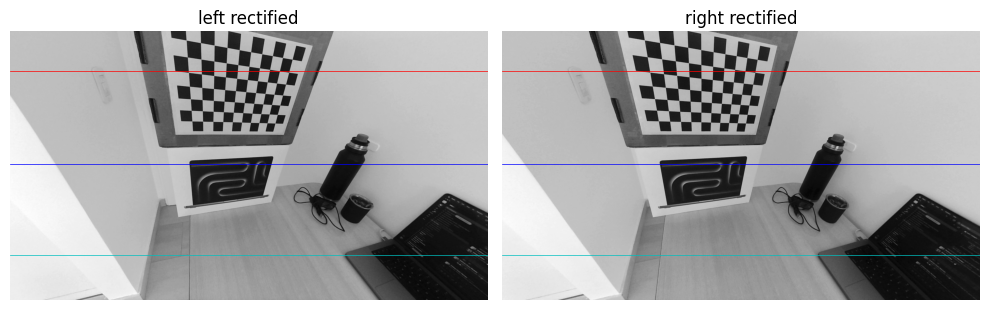

In [18]:
# muestro las imagenes stereo-rectificadas
# observar el vertice de la caja, de la notebook, y del cuaderno. 
# coinciden perfectamente en y.
from matplotlib import pyplot as plt 

fig, axes = show_images([
    left_image_rectified, right_image_rectified
], [
    "left rectified", "right rectified"
])

for y, c in zip([160, 533, 900], ['r', 'b', 'c']):
    axes[0].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
    axes[1].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
plt.show()

In [19]:
# Guardemos los resultados de rectificación para usar posteriormente:

stereo_maps = {

    # undistorting maps
    "left_map_x": left_map_x,
    "left_map_y": left_map_y,
    "right_map_x": right_map_x,
    "right_map_y": right_map_y,

    # add also rectifying info:
    "R1": R1,
    "R2": R2,
    "P1": P1,
    "P2": P2,
    "Q": Q,
    "validRoi1": validRoi1,
    "validRoi2": validRoi2,

}

stereo_maps_file = os.path.join("datasets","stereo_budha_board", "stereo_maps.pkl")
with open(stereo_maps_file, "wb") as f:
    f.write(pickle.dumps(stereo_maps))
        

## Rectificación Online

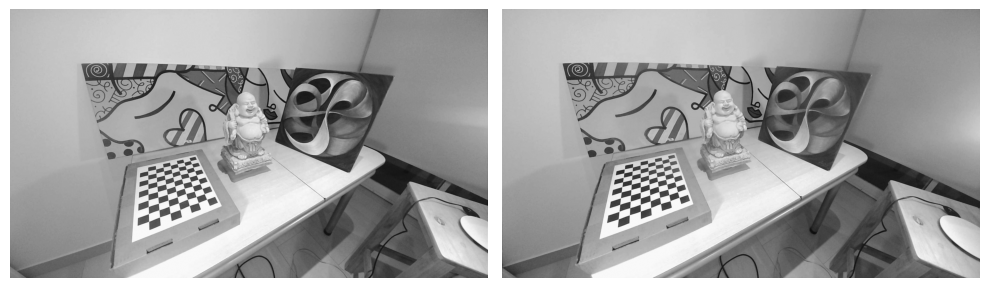

In [29]:
import os

left_image_file = os.path.join("datasets","stereo_budha_board", "captures", "left_0.jpg")
right_image_file = os.path.join("datasets","stereo_budha_board", "captures", "right_0.jpg")

left_image = cv2.imread(left_image_file, 0)
right_image = cv2.imread(right_image_file, 0)


fig, axes = show_images([left_image, right_image])

In [30]:
# cargamos la información de rectificación stereo, que generamos offline

import pickle


stereo_calib_file = os.path.join("datasets","stereo_budha_board", "stereo_calibration.pkl")
stereo_maps_file = os.path.join("datasets","stereo_budha_board", "stereo_maps.pkl")

print("reading stereo calibration results...")
with open(stereo_calib_file, "rb") as f:
    calibration = pickle.loads(f.read())
    
print("reading stereo rectification maps...")
with open(stereo_maps_file, "rb") as f:
    maps = pickle.loads(f.read())

reading stereo calibration results...
reading stereo rectification maps...


In [31]:
left_map_x, left_map_y = maps['left_map_x'], maps['left_map_y']
right_map_x, right_map_y = maps['right_map_x'], maps['right_map_y']



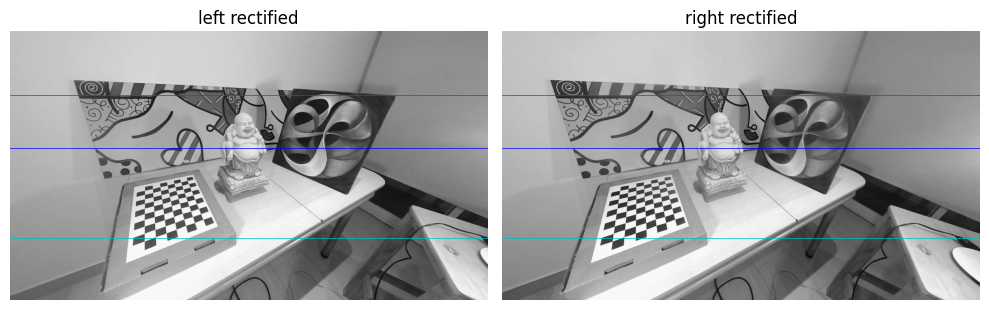

In [32]:
left_image_rectified = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
right_image_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)

cv2.imwrite("cat_left.jpg", left_image_rectified)
cv2.imwrite("cat_right.jpg", right_image_rectified)


fig, axes = show_images([
    left_image_rectified, right_image_rectified
], [
    "left rectified", "right rectified"
])

for y, c in zip([255, 470, 830], ['r', 'b', 'c']):
    axes[0].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
    axes[1].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
plt.show()

## Disparidad y Block Matching

Calculando disparidad (izquierda)...
Calculando disparidad (derecha)...
Aplicando filtro WLS...
¡Disparidad filtrada lista!


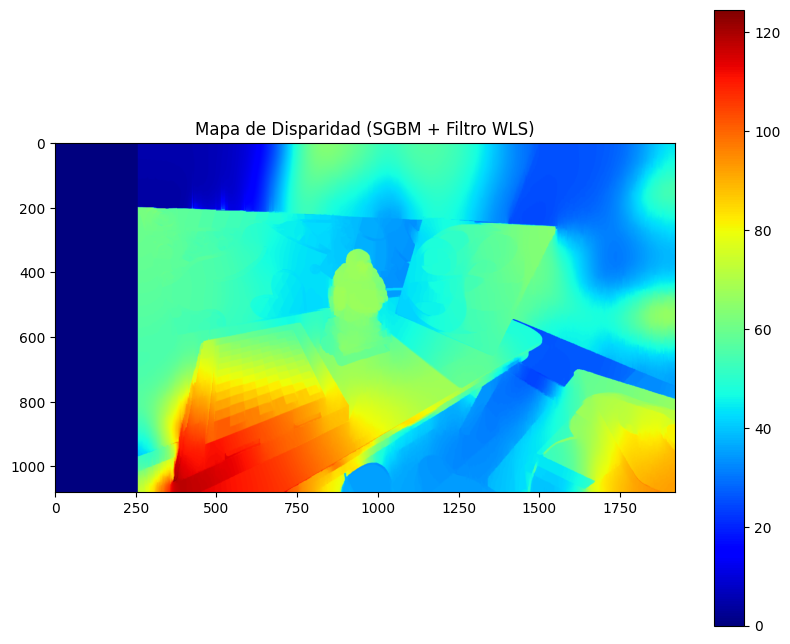

In [59]:
import cv2
import numpy as np
from cv2 import ximgproc  # Necesitas tener opencv-contrib-python instalado
import matplotlib.pyplot as plt

# --- 1. Configuración de SGBM (Semi-Global Block Matching) ---
# Estos parámetros son un buen punto de partida, como pide el PDF.

minDisparity = 0
numDisparities = 256  # Debe ser divisible por 16
blockSize = 5         # Un valor impar, 5 o 7 funciona bien
P1 = 8 * 3 * blockSize**2
P2 = 32 * 3 * blockSize**2
disp12MaxDiff = 1
uniquenessRatio = 10
speckleWindowSize = 100
speckleRange = 32
mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY # Modo más completo

# --- 2. Crear los Matchers (izquierdo y derecho) ---

# Matcher Izquierdo
stereo_sgbm = cv2.StereoSGBM_create(
    minDisparity=minDisparity,
    numDisparities=numDisparities,
    blockSize=blockSize,
    P1=P1,
    P2=P2,
    disp12MaxDiff=disp12MaxDiff,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    mode=mode
)

# Matcher Derecho (OBLIGATORIO para el filtro WLS)
right_matcher = ximgproc.createRightMatcher(stereo_sgbm)

# --- 3. Crear el Filtro WLS (la parte clave) ---
wls_filter = ximgproc.createDisparityWLSFilter(matcher_left=stereo_sgbm)
wls_filter.setLambda(8000.0)   # Parámetros de "suavizado"
wls_filter.setSigmaColor(1.5) # Parámetros de "respeto por el color"

# --- 4. Calcular y Filtrar la Disparidad ---

# Asumo que 'left_image_rectified' y 'right_image_rectified'
# ya están cargadas y son imágenes BGR (a color), no en gris.
# El filtro WLS usa la imagen a color como guía.

print("Calculando disparidad (izquierda)...")
disp_left = stereo_sgbm.compute(left_image_rectified, right_image_rectified)

print("Calculando disparidad (derecha)...")
disp_right = right_matcher.compute(right_image_rectified, left_image_rectified)

print("Aplicando filtro WLS...")
disparity_filtered = wls_filter.filter(disp_left, left_image_rectified, 
                                       disparity_map_right=disp_right)

# --- 5. Limpieza y Normalización ---

# El resultado del filtro se escala igual que el original
disparity_map = disparity_filtered.astype(np.float32) / 16.0

# Ponemos en 0 los valores inválidos (negativos) que genera el filtro
disparity_map[disparity_map < 0] = 0

# --- 6. Mostrar el resultado (¡Ahora sí!) ---

print("¡Disparidad filtrada lista!")
plt.figure(figsize=(10, 8))
plt.imshow(disparity_map, cmap='jet')
plt.title('Mapa de Disparidad (SGBM + Filtro WLS)')
plt.colorbar()
plt.show()

# IMPORTANTE:
# A partir de aquí, usa esta variable 'disparity_map' 
# para tu celda que calcula la profundidad (la de 'reprojectImageTo3D')

In [ ]:
# import numpy as np



# stereo = cv2.StereoBM_create(

#     numDisparities=256,

#     blockSize=15,

# )



# stereo.setPreFilterSize(31)

# stereo.setPreFilterCap(15)

# stereo.setMinDisparity(0)

# stereo.setTextureThreshold(7)

# stereo.setUniquenessRatio(3)

# stereo.setSpeckleWindowSize(512)

# # stereo.setSpeckleWindowSize(0)

# stereo.setSpeckleRange(32)

# stereo.setDisp12MaxDiff(23)





# # Cálculo del mapa de disparidad

# disparity_map = stereo.compute(

#     left_image_rectified,

#     right_image_rectified

# ).astype(np.float32) / 16.0



# plt.figure(figsize=(12, 6))

# plt.imshow(disparity_map)

# plt.colorbar()

# plt.show()



# import cv2

# import json

# import numpy as np

# from pathlib import Path





# # Ahora tus imports

# from disparidad.method_cre_stereo import CREStereo   # nombre exacto de la clase/archivo

# from disparidad.method_opencv_bm import StereoBM, StereoSGBM

# from disparidad.methods import Calibration, InputPair, Config

# w, h = left_image.shape[1], left_image.shape[0]

# fx = left_K[0][0]
# fy = left_K[1][1]
# cx0 = left_K[0][2]
# cy0 = left_K[1][2]

# baseline = np.linalg.norm(T)





# calibration = Calibration(**{

#     "width": w,

#     "height": h,

#     "baseline_meters": baseline / 1000,

#     "fx": fx,

#     "fy": fy,

#     "cx0": cx0,

#     "cx1": cx0,

#     "cy": cy0,

#     "depth_range": [0.05, 20.0],

#     "left_image_rect_normalized": [0, 0, 1, 1]

# })

# import os



# models_path = "models"

# if not os.path.exists(models_path):

#     os.makedirs(models_path)

# #models_path = Path.home() / ".cache" / "stereodemo" / "models"

# models_path = Path(models_path)

# pair = InputPair(left_image_rectified, right_image_rectified, calibration)

# # pair = InputPair(left_image, right_image, calibration)

# config = Config(models_path=models_path)



# # params = {

# #    "Shape": "1280x720",

# #    "Mode": "combined",

# #    "Iterations": 20

# #}

# method = CREStereo(config)



# #method.parameters["Shape"].set_value("640x480")

# method.parameters["Shape"].set_value("1280x720")

# # method.parameters["Iterations"].set_value("10")



# #method.parameters.update(params)

# # method = StereoBM(config)

# # method = StereoSGBM(config)

# # method = StereoBM(config)

# disparity = method.compute_disparity(pair)

# plt.figure(figsize=(12, 6))

# plt.imshow(disparity.disparity_pixels)

# plt.colorbar()

# plt.show()

## Profundidad

Reproyectando a 3D...
Graficando profundidad. Rango: 286.43 a 1440.85 mm


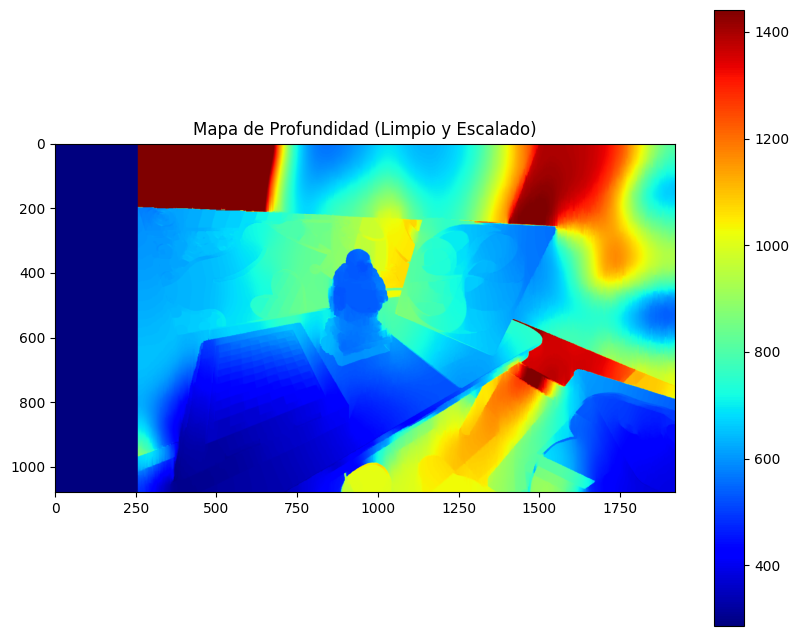

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Reproyectar a 3D ---
# Usa el 'disparity_map' limpio que creaste en el paso anterior
# y la matriz 'Q' que calculaste en la celda [11]
print("Reproyectando a 3D...")
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

# --- 2. Extraer el Mapa de Profundidad ---
# La profundidad es el canal Z (índice 2)
depth = points_3D[:, :, 2]

# --- 3. Limpieza de 'inf' y 'nan' (¡LA PARTE CLAVE!) ---
# Creamos una máscara de todos los píxeles válidos:
#   - Donde la disparidad NO es 0 (evita división por cero)
#   - Donde el resultado de depth NO es infinito
#   - Donde el resultado de depth NO es "nan" (Not a Number)
valid_mask = (disparity_map > 0) & \
             (~np.isinf(depth)) & \
             (~np.isnan(depth))

# Creamos un nuevo mapa de profundidad limpio
# Lleno de ceros al principio
depth_cleaned = np.zeros_like(depth)

# Copiamos SÓLO los valores válidos al mapa limpio
depth_cleaned[valid_mask] = depth[valid_mask]


# --- 4. Plotear con Escala de Color Inteligente ---
# Si ploteamos de 0 al máximo, el fondo arruina la escala.
# Debemos plotear desde la distancia MÍNIMA a la MÁXIMA del objeto.

# Encontrar el valor más CERCANO (mínimo) del objeto
vmin_plot = np.min(depth_cleaned[valid_mask])

# Encontrar el valor más LEJANO (máximo) del objeto
# Usamos un percentil (ej: 95%) para ignorar "outliers" o puntos ruidosos lejanos
vmax_plot = np.percentile(depth_cleaned[valid_mask], 95)

print(f"Graficando profundidad. Rango: {vmin_plot:.2f} a {vmax_plot:.2f} mm")

plt.figure(figsize=(10, 8))
plt.imshow(depth_cleaned, cmap='jet', vmin=vmin_plot, vmax=vmax_plot)
plt.title('Mapa de Profundidad (Limpio y Escalado)')
plt.colorbar()
plt.show()

# IMPORTANTE:
# La variable 'points_3D' es tu nube de puntos.
# La variable 'depth_cleaned' es tu mapa de profundidad 2D para el informe.

In [ ]:
# def compute_depth(disparity_map, f, B, default=1000.0):

#     # Crea una copia del mapa de disparidad
#     disparity_map = disparity_map.copy()
    
#     # Evita divisiones por cero o disparidades negativas (les asignamos el valor default)
#     mask_invalid = (disparity_map <= 0)
    
#     # Calcula la profundidad con la fórmula Z = f * B / disparidad
#     depth_map = np.zeros_like(disparity_map, dtype=np.float32)
#     depth_map[~mask_invalid] = (f * B) / disparity_map[~mask_invalid]
    
#     # Asigna valor fijo a los puntos donde la disparidad es inválida
#     depth_map[mask_invalid] = default
    
#     return depth_map


# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Asumo que tienes 'disparity_map' (en píxeles) y 'Q' (de la celda [11])

# # 1. Reproyectar la imagen de disparidad a un espacio 3D
# #    Esto crea una imagen de 3 canales (X, Y, Z)
# points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

# # 2. El mapa de profundidad es simplemente el canal Z (índice 2)
# depth = points_3D[:, :, 2]

# # 3. Limpiar para la visualización
# #    Igual que antes, enmascaramos los valores inválidos
# valid_mask = disparity_map > 0
# depth[~valid_mask] = 0.0 # Pone 0 donde la máscara es False

# # 4. Plotear (con el mismo truco de vmin/vmax para ver mejor)
# vmax_plot = np.percentile(depth[valid_mask], 95)
# vmin_plot = np.min(depth[valid_mask]) # El mínimo real, no 0

# plt.figure(figsize=(10, 8))
# plt.imshow(depth, cmap='jet', vmin=vmin_plot, vmax=vmax_plot) 
# plt.title('Depth Map (Método Q)')
# plt.colorbar()
# plt.show()

## Boluda quedo re chat este bloque perdon tiene hasta emojis

In [67]:
import cv2
import numpy as np
import open3d as o3d
import glob # Para encontrar tus imágenes
import matplotlib.pyplot as plt
import os

# --------------------------------------------------------------------------
# --- PRE-REQUISITOS (¡COMPLETA ESTO CON TUS VARIABLES!) ---
# --------------------------------------------------------------------------




# 1. De tu celda de calibración (ej: celda [10])
left_K = left_K # Tu matriz K de la cámara izquierda
left_D = left_dist # Tus coeficientes de distorsión de la cámara izquierda

# 2. De tu celda de rectificación (ej: celda [11])
Q = Q             # Tu matriz Q de reprojectImageTo3D
left_rect_map1 = left_map_x  # Tu mapa de rectificación 1
left_rect_map2 = left_map_y  # Tu mapa de rectificación 2
right_rect_map1 = right_map_x # Tu mapa de rectificación 1
right_rect_map2 = right_map_y # Tu mapa de rectificación 2

# 3. De tu celda de calibración (ej: celdas [2], [3])
checkerboard = (10, 7)
square_size_mm = 24.2 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Puntos 3D del "mundo" (el tablero)
objp = np.zeros((checkerboard[0] * checkerboard[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard[0], 0:checkerboard[1]].T.reshape(-1, 2)
objp = objp * square_size_mm

# 4. Parámetros del filtro SGBM+WLS (los que te pasé antes)
#    (Los pongo aquí para que el script sea completo)
minDisparity = 0
numDisparities = 256 
blockSize = 5
P1 = 8 * 3 * blockSize**2
P2 = 32 * 3 * blockSize**2
disp12MaxDiff = 1
uniquenessRatio = 10
speckleWindowSize = 100
speckleRange = 32
mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY

stereo_sgbm = cv2.StereoSGBM_create(
    minDisparity=minDisparity, numDisparities=numDisparities, blockSize=blockSize,
    P1=P1, P2=P2, disp12MaxDiff=disp12MaxDiff,
    uniquenessRatio=uniquenessRatio, speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange, mode=mode
)
right_matcher = ximgproc.createRightMatcher(stereo_sgbm)
wls_filter = ximgproc.createDisparityWLSFilter(matcher_left=stereo_sgbm)
wls_filter.setLambda(8000.0)
wls_filter.setSigmaColor(1.5)

# --------------------------------------------------------------------------
# --- BUCLE DE RECONSTRUCCIÓN ---
# --------------------------------------------------------------------------

# Listas para guardar los puntos y colores de TODAS las vistas
all_points_world = []
all_colors_world = []

# IMPORTANTE: Asumo que tus imágenes de reconstrucción están en un 
# directorio y se llaman 'left_01.jpg', 'right_01.jpg', 'left_02.jpg', etc.
# ¡CAMBIA ESTE PATH!

import os
import glob

# --- INICIO DE LA CORRECCIÓN ---

# 1. Definir la ruta RELATIVA (basado en tu captura de pantalla)
#    os.path.join se encargará de poner las barras \ o / correctamente.
reconstruction_path = os.path.join("datasets", "stereo_budha_board", "captures")

# 2. Crear los patrones de búsqueda
left_pattern = os.path.join(reconstruction_path, "left_*.jpg")
right_pattern = os.path.join(reconstruction_path, "right_*.jpg")

# --- PASO DE DEPURACIÓN (¡MUY IMPORTANTE!) ---
# Vamos a imprimir el patrón exacto que glob está buscando.
print(f"Buscando archivos que coincidan con: {left_pattern}")

# 3. Ejecutar glob con el patrón
left_image_paths = sorted(glob.glob(left_pattern))
right_image_paths = sorted(glob.glob(right_pattern))

# --- FIN DE LA CORRECCIÓN ---

# El resto de tu código...
print(f"Encontradas {len(left_image_paths)} pares de imágenes para reconstruir.")

# Opcional: imprime los archivos que encontró
# print("Archivos encontrados:")
# print(left_image_paths)


# reconstruction_path = r"C:\vision_artificial\tp2_git\tp2_reconstruccion_3d\datasets\stereo_budha_board\captures"
# left_image_paths = sorted(glob.glob(reconstruction_path + "left_*.jpg"))
# right_image_paths = sorted(glob.glob(reconstruction_path + "right_*.jpg"))

# print(f"Encontradas {len(left_image_paths)} pares de imágenes para reconstruir.")

for left_path, right_path in zip(left_image_paths, right_image_paths):
    print(f"Procesando par: {left_path} y {right_path}")

    # Cargar imágenes ORIGINALES
    left_view_img = cv2.imread(left_path)
    right_view_img = cv2.imread(right_path)
    if left_view_img is None:
        print(f"Error cargando imagen {left_path}")
        continue

    # --- PASO 1 y 2: Rectificar y Calcular Puntos 3D ---
    
    # Rectificar imágenes
    left_image_rectified = cv2.remap(left_view_img, left_rect_map1, left_rect_map2, cv2.INTER_LINEAR)
    right_image_rectified = cv2.remap(right_view_img, right_rect_map1, right_rect_map2, cv2.INTER_LINEAR)

    # Calcular disparidad (con SGBM + WLS)
    disp_left = stereo_sgbm.compute(left_image_rectified, right_image_rectified)
    disp_right = right_matcher.compute(right_image_rectified, left_image_rectified)
    disparity_filtered = wls_filter.filter(disp_left, left_image_rectified, disparity_map_right=disp_right)
    disparity_map = disparity_filtered.astype(np.float32) / 16.0

    # Calcular Puntos 3D (en sistema de la CÁMARA)
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
    
    # Limpieza de valores 'inf'
    valid_mask = (disparity_map > 0) & (~np.isinf(points_3D[:, :, 2]))
    
    # Obtener los puntos 3D válidos
    points_cam = points_3D[valid_mask]
    
    # Obtener los colores (necesitamos RGB para Open3D, no BGR)
    colors_cam = cv2.cvtColor(left_image_rectified, cv2.COLOR_BGR2RGB)[valid_mask]

    # --- PASO 3: Calcular Pose de la Cámara (solvePnP) ---
    
    # Usar la imagen IZQUIERDA ORIGINAL (no rectificada)
    gray = cv2.cvtColor(left_view_img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard, None)
    
    if ret:
        print("Tablero encontrado. Calculando pose...")
        # Refinar esquinas
        corners_subpix = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        
        # Calcular pose (rvec y tvec)
        # Esto nos da la transformación del MUNDO (tablero) a la CÁMARA
        ret, rvec, tvec = cv2.solvePnP(objp, corners_subpix, left_K, left_D)

        # --- PASO 4: Transformar Puntos al Sistema del MUNDO ---
        
        # Necesitamos la transformación INVERSA: de CÁMARA a MUNDO
        R, _ = cv2.Rodrigues(rvec) # Matriz de rotación (3x3)
        R_T = R.T                   # Inversa de la rotación es la transpuesta
        
        # p_mundo = R.T * (p_camara - tvec)
        # O en NumPy: p_mundo = (p_camara @ R.T) + (-R.T @ tvec).T
        
        # Calcular la nueva traslación
        t_world = -R_T @ tvec
        
        # Aplicar transformación a TODOS los puntos de esta vista
        points_world = (points_cam @ R_T) + t_world.T # .T para broadcasting
        
        # --- PASO 6: Acumular Puntos ---
        all_points_world.append(points_world)
        all_colors_world.append(colors_cam)
        print(f"¡Vista procesada! {len(points_world)} puntos añadidos.")
        
    else:
        print("ADVERTENCIA: No se encontró el tablero en esta vista. Se omitirá.")

# --------------------------------------------------------------------------
# --- ENSAMBLAJE FINAL (Open3D) ---
# --------------------------------------------------------------------------

print("Ensamblando nube de puntos final...")

# Combinar todas las listas de puntos en un solo array de NumPy
final_points = np.concatenate(all_points_world, axis=0)
final_colors = np.concatenate(all_colors_world, axis=0)

# Normalizar colores a [0, 1] para Open3D
final_colors_normalized = final_colors.astype(np.float64) / 255.0

# Crear la nube de puntos de Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(final_points)
pcd.colors = o3d.utility.Vector3dVector(final_colors_normalized)

# --- PASO 5 (Opcional): Optimización/Limpieza ---
print("Limpiando nube de puntos (Voxel Downsampling y Outliers)...")

# 1. Voxel Downsample: reduce la densidad de la nube a 2mm
voxel_size_mm = 2.0 
pcd_downsampled = pcd.voxel_down_sample(voxel_size=voxel_size_mm)

# 2. Statistical Outlier Removal: elimina puntos ruidosos
nb_neighbors = 20
std_ratio = 2.0
pcd_filtered, ind = pcd_downsampled.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
print(f"Nube original: {len(pcd.points)} puntos. Nube filtrada: {len(pcd_filtered.points)} puntos.")


# --- PASO 6: Visualización ---
print("Mostrando reconstrucción 3D. ¡Cierra la ventana para guardar!")

# (Sugerencia) Crear un eje de coordenadas (el (0,0,0) del tablero)
world_axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50.0, origin=[0, 0, 0]) # 50mm

o3d.visualization.draw_geometries([pcd_filtered, world_axes])


# --- PASO 7: Guardar Archivo .PLY ---
output_file = "reconstruccion_buda_final.ply"
print(f"Guardando nube de puntos en: {output_file}")
o3d.io.write_point_cloud(output_file, pcd_filtered, write_ascii=False)

print("¡Trabajo práctico terminado! 🎉")

Buscando archivos que coincidan con: datasets\stereo_budha_board\captures\left_*.jpg
Encontradas 6 pares de imágenes para reconstruir.
Procesando par: datasets\stereo_budha_board\captures\left_0.jpg y datasets\stereo_budha_board\captures\right_0.jpg
Tablero encontrado. Calculando pose...
¡Vista procesada! 1797098 puntos añadidos.
Procesando par: datasets\stereo_budha_board\captures\left_1.jpg y datasets\stereo_budha_board\captures\right_1.jpg
Tablero encontrado. Calculando pose...
¡Vista procesada! 1797111 puntos añadidos.
Procesando par: datasets\stereo_budha_board\captures\left_2.jpg y datasets\stereo_budha_board\captures\right_2.jpg
Tablero encontrado. Calculando pose...
¡Vista procesada! 1797120 puntos añadidos.
Procesando par: datasets\stereo_budha_board\captures\left_3.jpg y datasets\stereo_budha_board\captures\right_3.jpg
Tablero encontrado. Calculando pose...
¡Vista procesada! 1796987 puntos añadidos.
Procesando par: datasets\stereo_budha_board\captures\left_4.jpg y datasets\st